# Imports

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import xml.etree.ElementTree as ET

# Load in data

In [3]:
path = os.path.join(os.getcwd(), 'data', 'apple_health_export/')

tree = ET.parse(path + 'export.xml') 
root = tree.getroot()
# record_list = [x.attrib for x in root.iter('Record')]

In [4]:
# print all the elements 
data_types = set()

for elem in root.iter():
    data_types.add(elem.tag)

print(data_types)

{'WorkoutRoute', 'Record', 'WorkoutStatistics', 'WorkoutEvent', 'FileReference', 'HealthData', 'HeartRateVariabilityMetadataList', 'ExportDate', 'Me', 'InstantaneousBeatsPerMinute', 'ActivitySummary', 'Workout', 'MetadataEntry'}


In [5]:
# Function to load data from root into a pandas dataframe
def load_dataframe(type):
    return pd.DataFrame([x.attrib for x in root.iter(type)])

## Record data

In [23]:
record_data = load_dataframe('Record')

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    record_data[col] = pd.to_datetime(record_data[col])

# value is numeric, NaN if fails
record_data['value'] = pd.to_numeric(record_data['value'], errors='coerce')

# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
record_data['value'] = record_data['value'].fillna(1.0)

# shorter observation names
record_data['type'] = record_data['type'].str.replace('HKQuantityTypeIdentifier', '')
record_data['type'] = record_data['type'].str.replace('HKCategoryTypeIdentifier', '')
record_data.tail()

,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
1957733,HeartRateVariabilitySDNN,Adam’s Apple Watch,10.4,ms,2024-04-15 19:06:33-04:00,2024-04-15 19:05:32-04:00,2024-04-15 19:06:22-04:00,42.6500,"<<HKDevice: 0x302cc7e80>, name:Apple Watch, ma..."
1957734,HeartRateVariabilitySDNN,Adam’s Apple Watch,10.4,ms,2024-04-15 22:16:38-04:00,2024-04-15 22:15:36-04:00,2024-04-15 22:16:36-04:00,17.7810,"<<HKDevice: 0x302cc7e80>, name:Apple Watch, ma..."
1957735,HeartRateVariabilitySDNN,Adam’s Apple Watch,10.4,ms,2024-04-15 22:39:22-04:00,2024-04-15 22:38:21-04:00,2024-04-15 22:39:21-04:00,72.5745,"<<HKDevice: 0x302cc7e80>, name:Apple Watch, ma..."
1957736,HeartRateVariabilitySDNN,Adam’s Apple Watch,10.4,ms,2024-04-15 23:28:40-04:00,2024-04-15 23:27:39-04:00,2024-04-15 23:28:39-04:00,42.3054,"<<HKDevice: 0x302cc7e80>, name:Apple Watch, ma..."
1957737,HeartRateVariabilitySDNN,Adam’s Apple Watch,10.4,ms,2024-04-16 01:03:51-04:00,2024-04-16 01:02:50-04:00,2024-04-16 01:03:49-04:00,49.4021,"<<HKDevice: 0x302cc7e80>, name:Apple Watch, ma..."


## Workout data

In [36]:
workout_list = [x.attrib for x in root.iter('Workout')]

# create DataFrame
workout_data = pd.DataFrame(workout_list)
workout_data['workoutActivityType'] = workout_data['workoutActivityType'].str.replace('HKWorkoutActivityType', '')
workout_data = workout_data.rename({"workoutActivityType": "Type"}, axis=1)

# # proper type to dates
# for col in ['creationDate', 'startDate', 'endDate']:
#     workout_data[col] = pd.to_datetime(workout_data[col])

# # convert string to numeric   
# workout_data['duration'] = pd.to_numeric(workout_data['duration'])
# workout_data['totalEnergyBurned'] = pd.to_numeric(workout_data['totalEnergyBurned'])
# workout_data['totalDistance'] = pd.to_numeric(workout_data['totalDistance'])
# workout_data.tail()

In [44]:
print(data_types)

{'HealthData', 'WorkoutStatistics', 'Me', 'HeartRateVariabilityMetadataList', 'WorkoutEvent', 'WorkoutRoute', 'MetadataEntry', 'ExportDate', 'FileReference', 'InstantaneousBeatsPerMinute', 'Record', 'ActivitySummary', 'Workout'}


In [171]:
df = load_dataframe('HealthData')
df

,locale
0,en_CA


In [165]:
activeCals = df.activeEnergyBurned.astype(float)
print("Total calories burned since I got the watch: ", activeCals.sum())

Total calories burned since I got the watch:  951048.4548


In [168]:
averageCalsBurnedPerDay = activeCals.sum() / num_days 
print("Average calories burned per day: ", averageCalsBurnedPerDay)

Average calories burned per day:  889.6617912067352


In [169]:
50000 / averageCalsBurnedPerDay

56.2011322664314

In [157]:
dates = pd.to_datetime(df.dateComponents)
days = dates.iloc[-1] - dates.iloc[0]
num_days = days.days
print(num_days)

1069


In [159]:
len(df) / num_days  *100

91.67446211412536

In [160]:
903 / len(df)  * 100

92.14285714285714

In [162]:
print("Number of days I excersised since I got the watch:", 903 / num_days * 100)

Number of days I excersised since I got the watch: 84.47146866230122


In [80]:
df = load_dataframe('Workout')
df

,workoutActivityType,duration,durationUnit,sourceName,sourceVersion,device,creationDate,startDate,endDate
0,HKWorkoutActivityTypeWalking,12.87223668297132,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x302ca6f30>, name:Apple Watch, ma...",2021-07-13 11:23:53 -0400,2021-07-13 11:11:00 -0400,2021-07-13 11:23:53 -0400
1,HKWorkoutActivityTypeDiscSports,55.56390554904938,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x302ca6f30>, name:Apple Watch, ma...",2021-07-13 18:33:24 -0400,2021-07-13 17:37:49 -0400,2021-07-13 18:33:23 -0400
2,HKWorkoutActivityTypeRunning,1.410094485680262,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x302ca6f30>, name:Apple Watch, ma...",2021-07-13 18:37:48 -0400,2021-07-13 18:35:35 -0400,2021-07-13 18:37:47 -0400
3,HKWorkoutActivityTypeTraditionalStrengthTraining,56.02488265236219,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x302ca6f30>, name:Apple Watch, ma...",2021-07-13 20:23:46 -0400,2021-07-13 19:20:27 -0400,2021-07-13 20:23:45 -0400
4,HKWorkoutActivityTypeWalking,16.15754281679789,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x302ca6f30>, name:Apple Watch, ma...",2021-07-14 11:04:12 -0400,2021-07-14 10:48:02 -0400,2021-07-14 11:04:12 -0400
...,...,...,...,...,...,...,...,...,...
988,HKWorkoutActivityTypeTennis,77.04600946704547,min,Adam’s Apple Watch,10.4,"<<HKDevice: 0x302cff430>, name:Apple Watch, ma...",2024-04-14 18:33:33 -0400,2024-04-14 17:16:22 -0400,2024-04-14 18:33:25 -0400
989,HKWorkoutActivityTypeWalking,26.83665318489075,min,Adam’s Apple Watch,10.4,"<<HKDevice: 0x302cff430>, name:Apple Watch, ma...",2024-04-15 13:27:04 -0400,2024-04-15 13:00:09 -0400,2024-04-15 13:26:59 -0400
990,HKWorkoutActivityTypeWalking,32.02597273389498,min,Adam’s Apple Watch,10.4,"<<HKDevice: 0x302cff430>, name:Apple Watch, ma...",2024-04-15 17:07:28 -0400,2024-04-15 16:35:22 -0400,2024-04-15 17:07:24 -0400
991,HKWorkoutActivityTypeTraditionalStrengthTraining,93.17174258430799,min,Adam’s Apple Watch,10.4,"<<HKDevice: 0x302cff430>, name:Apple Watch, ma...",2024-04-15 21:27:32 -0400,2024-04-15 19:54:14 -0400,2024-04-15 21:27:24 -0400


In [79]:
# types of statistics 
stat_types = df['type'].unique()
print(stat_types)

['HKQuantityTypeIdentifierActiveEnergyBurned'
 'HKQuantityTypeIdentifierDistanceWalkingRunning'
 'HKQuantityTypeIdentifierBasalEnergyBurned'
 'HKQuantityTypeIdentifierHeartRate' 'HKQuantityTypeIdentifierStepCount'
 'HKQuantityTypeIdentifierRunningGroundContactTime'
 'HKQuantityTypeIdentifierRunningPower'
 'HKQuantityTypeIdentifierRunningVerticalOscillation'
 'HKQuantityTypeIdentifierRunningSpeed'
 'HKQuantityTypeIdentifierRunningStrideLength'
 'HKQuantityTypeIdentifierDistanceCycling']


In [75]:
df = load_dataframe('Workout')
workout_types = df['workoutActivityType'].str.replace('HKWorkoutActivityType', '').unique()
print(workout_types)

['Walking' 'DiscSports' 'Running' 'TraditionalStrengthTraining' 'Yoga'
 'TableTennis' 'Other' 'CoreTraining' 'Tennis' 'Golf' 'Hiking'
 'HighIntensityIntervalTraining' 'SkatingSports' 'Cycling' 'Rowing'
 'Volleyball' 'Soccer' 'FunctionalStrengthTraining' 'Squash'
 'AmericanFootball' 'Hockey' 'Cooldown' 'Basketball' 'CardioDance' 'Rugby']


# Building full workout dataframe 

This issue here is that workout types, start, and end dates are saved in "Workout" but the calorie data, distance run, etc. is all saved in "WorkoutStatistics", so I need to figure out how to merge these two datasets. The best way to do this is to align the start and end times. 

In [138]:
workouts = load_dataframe('Workout')
stats = load_dataframe('WorkoutStatistics')
activity = load_dataframe('ActivitySummary')

In [139]:
# start out with the workouts dataframe 
df = workouts.copy()

# convert dates to datetime object 
for col in ['creationDate', 'startDate', 'endDate']:
    df[col] = pd.to_datetime(df[col])

for col in ["startDate", "endDate"]:
    stats[col] = pd.to_datetime(stats[col])

# drop the unnecessary columns
df.drop(columns=['sourceName', 'sourceVersion', 'device'], inplace=True)

# create a new column with clean workout type 
df['Type'] = df['workoutActivityType'].str.replace('HKWorkoutActivityType', '')

# change name of all the type elements to remove HKQuantityTypeIdentifier
stats['type'] = stats['type'].str.replace('HKQuantityTypeIdentifier', '')

In [140]:
# provides safe access to data that may not exist
def access(call):
    try: 
        return call()
    except:
        return np.nan

In [141]:
statistics_columns = ["activeCalories", "basalCalories", "distance", "avgHeartRate", "minHeartRate", "maxHeartRate", "avgRunSpeed", "minRunSpeed", "maxRunSpeed"]
statistics = []

for i in range(len(df)):
    workout = df.iloc[i]
    start = workout.startDate

    recordedStats = stats[stats.startDate == start]

    # Create np.nans if no data is available for a workout 
    if len(recordedStats) == 0:
        workout_stats =  [np.nan] * len(statistics_columns)

    else:
        activeCalories = access(lambda: recordedStats.loc[recordedStats["type"] == "ActiveEnergyBurned"]["sum"].values[0])
        basalCalories = access(lambda: recordedStats.loc[recordedStats["type"] == "BasalEnergyBurned"]["sum"].values[0])
        distance = access(lambda: recordedStats.loc[recordedStats["type"] == "DistanceWalkingRunning"]["sum"].values[0])
        avgHeartRate = access(lambda: recordedStats.loc[recordedStats["type"] == "HeartRate"]["average"].values[0])
        minHeartRate = access(lambda: recordedStats.loc[recordedStats["type"] == "HeartRate"]["minimum"].values[0])
        maxHeartRate = access(lambda: recordedStats.loc[recordedStats["type"] == "HeartRate"]["maximum"].values[0])
        avgSpeed = access(lambda: recordedStats.loc[recordedStats["type"] == "RunningSpeed"]["average"].values[0])
        minSpeed = access(lambda: recordedStats.loc[recordedStats["type"] == "RunningSpeed"]["minimum"].values[0])
        maxSpeed = access(lambda: recordedStats.loc[recordedStats["type"] == "RunningSpeed"]["maximum"].values[0])
 
        workout_stats = [activeCalories, basalCalories, distance, avgHeartRate, minHeartRate, maxHeartRate, avgSpeed, minSpeed, maxSpeed]

    statistics.append(workout_stats)

# add to datafram 
statstics = np.array(statistics)

for i, col in enumerate(statistics_columns):
    df[col] = statstics[:,i]


In [143]:
numeric_columns = ["duration", "activeCalories", "basalCalories", "distance", "avgHeartRate", "minHeartRate", "maxHeartRate", "avgRunSpeed", "minRunSpeed", "maxRunSpeed"]

for col in numeric_columns:
    df[col] = df[col].astype(float)

# Analysis

## Average weekly calories burned 

In [70]:
# compute and plot the average active calories burned per week 
data = df.copy()
data = data[["creationDate", "duration", "avgHeartRate", "activeCalories", "basalCalories"]]

In [71]:
data.set_index('creationDate', inplace=True)

In [72]:
data['totalCalories'] = data['activeCalories'] + data['basalCalories']

In [74]:
data = data.fillna(0)

,duration,avgHeartRate,activeCalories,basalCalories,totalCalories
creationDate,,,,,
2021-07-13 11:23:53-04:00,12.872237,0.000,78.46930,21.56530,100.03460
2021-07-13 18:33:24-04:00,55.563906,0.000,383.88700,94.01800,477.90500
2021-07-13 18:37:48-04:00,1.410094,0.000,6.36811,2.39157,8.75968
2021-07-13 20:23:46-04:00,56.024883,0.000,464.89200,93.93160,558.82360
2021-07-14 11:04:12-04:00,16.157543,0.000,56.26220,27.14070,83.40290
...,...,...,...,...,...
2024-04-14 18:33:33-04:00,77.046009,137.097,830.86600,126.49300,957.35900
2024-04-15 13:27:04-04:00,26.836653,104.589,124.58800,44.05050,168.63850
2024-04-15 17:07:28-04:00,32.025973,89.140,115.51800,52.59880,168.11680


In [112]:
monthly_total = data['totalCalories'].resample('M').sum()
monthly_active = data['activeCalories'].resample('M').sum()

In [106]:
df.Type.unique()

array(['Walking', 'DiscSports', 'Running', 'TraditionalStrengthTraining',
       'Yoga', 'TableTennis', 'Other', 'CoreTraining', 'Tennis', 'Golf',
       'Hiking', 'HighIntensityIntervalTraining', 'SkatingSports',
       'Cycling', 'Rowing', 'Volleyball', 'Soccer',
       'FunctionalStrengthTraining', 'Squash', 'AmericanFootball',
       'Hockey', 'Cooldown', 'Basketball', 'CardioDance', 'Rugby'],
      dtype=object)

In [123]:
# get tennis and gym only 
tennis = df.loc[df.Type=="Tennis"]
gym = df.loc[(df.Type=="TraditionalStrengthTraining") |  (df.Type == "FunctionalStrengthTraining")]
running = df.loc[df.Type=="Running"]

tennis = tennis[["creationDate", "duration", "avgHeartRate", "activeCalories", "basalCalories"]]
gym = gym[["creationDate", "duration", "avgHeartRate", "activeCalories", "basalCalories"]]
running = running[["creationDate", "duration", "avgHeartRate", "activeCalories", "basalCalories"]]

tennis.set_index('creationDate', inplace=True)
gym.set_index('creationDate', inplace=True)
running.set_index('creationDate', inplace=True)

tennis["totalCalories"] = tennis["activeCalories"] + tennis["basalCalories"]
gym["totalCalories"] = gym["activeCalories"] + gym["basalCalories"]
running["totalCalories"] = running["activeCalories"] + running["basalCalories"]

tennis = tennis.fillna(0)
gym = gym.fillna(0)
running = running.fillna(0)

monthly_tennis = tennis['totalCalories'].resample('M').sum()
monthly_gym = gym['totalCalories'].resample('M').sum()
monthly_run = running['totalCalories'].resample('M').sum()

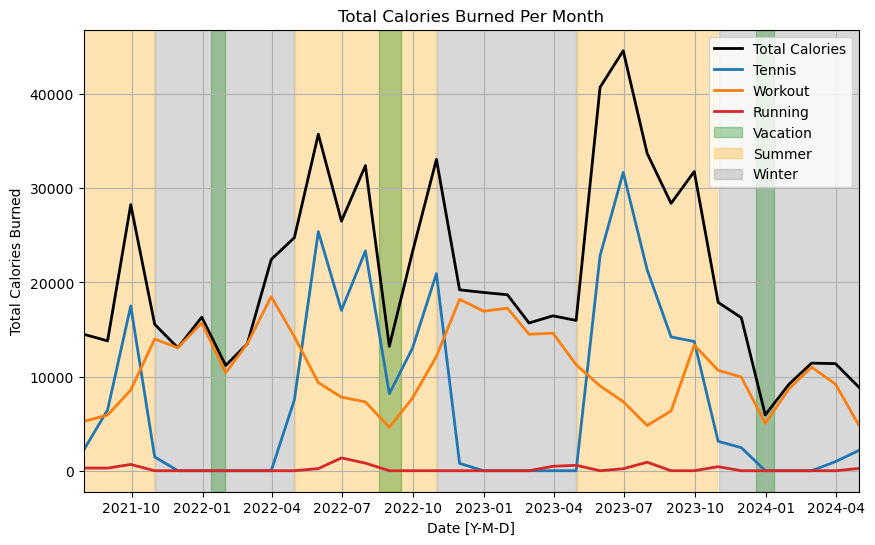

In [126]:
# Plotting the total calories burned per week
plt.figure(figsize=(10, 6))
plt.plot(monthly_total, color='k', lw=2, label="Total Calories")
plt.plot(monthly_tennis, color='C0', lw=2, label="Tennis")
plt.plot(monthly_gym, color='C1', lw=2, label="Workout")
# plt.plot(monthly_run, color='C3', lw=2, label="Running")

for year in range(2021, 2024):
    plt.axvspan(pd.Timestamp(f'{year}-05-01'), pd.Timestamp(f'{year}-10-30'), color='orange', alpha=0.3)

for year in range(2021, 2024):
    next_year = year+1
    plt.axvspan(pd.Timestamp(f'{year}-11-01'), pd.Timestamp(f'{next_year}-04-30'), color='gray', alpha=0.3)

plt.axvspan(pd.Timestamp('2022-01-12'), pd.Timestamp('2022-01-30'), color='green', alpha=0.3, label="Vacation")
plt.axvspan(pd.Timestamp('2022-08-18'), pd.Timestamp('2022-09-15'), color='green', alpha=0.3)
plt.axvspan(pd.Timestamp('2023-12-19'), pd.Timestamp('2024-01-12'), color='green', alpha=0.3)

plt.axvspan(np.nan, np.nan, color='orange', alpha=0.3, label="Summer")
plt.axvspan(np.nan, np.nan, color='gray', alpha=0.3, label="Winter")

plt.title('Total Calories Burned Per Month')
plt.xlabel('Date [Y-M-D]')
plt.ylabel('Total Calories Burned')
plt.grid(True)
plt.legend()
plt.xlim(monthly_total.index[0], monthly_total.index[-1])
# plt.savefig("plots/total_calories.png")
plt.show()

## Step count

In [150]:
data = stats.copy()
data.loc[data.type == "StepCount"]["sum"]

1520       3653
1546    2357.09
1590    3903.88
1609       3554
1881       2364
2042       2099
2078    3035.32
2100       3808
2517       4733
2921       2983
Name: sum, dtype: object

In [146]:
data

,type,startDate,endDate,sum,unit,average,minimum,maximum
0,ActiveEnergyBurned,2021-07-13 11:11:00-04:00,2021-07-13 11:23:53-04:00,78.4693,Cal,NaN,NaN,NaN
1,DistanceWalkingRunning,2021-07-13 11:11:00-04:00,2021-07-13 11:23:53-04:00,1.30216,km,NaN,NaN,NaN
2,BasalEnergyBurned,2021-07-13 11:11:00-04:00,2021-07-13 11:23:53-04:00,21.5653,Cal,NaN,NaN,NaN
3,ActiveEnergyBurned,2021-07-13 17:37:49-04:00,2021-07-13 18:33:23-04:00,383.887,Cal,NaN,NaN,NaN
4,BasalEnergyBurned,2021-07-13 17:37:49-04:00,2021-07-13 18:33:23-04:00,94.018,Cal,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2953,BasalEnergyBurned,2024-04-15 19:54:14-04:00,2024-04-15 21:27:24-04:00,151.314,Cal,NaN,NaN,NaN
2954,DistanceWalkingRunning,2024-04-16 10:39:31-04:00,2024-04-16 11:04:00-04:00,2.22902,km,NaN,NaN,NaN
2955,BasalEnergyBurned,2024-04-16 10:39:31-04:00,2024-04-16 11:04:00-04:00,40.1669,Cal,NaN,NaN,NaN
2956,HeartRate,2024-04-16 10:39:31-04:00,2024-04-16 11:04:00-04:00,NaN,count/min,110.9,104,125
